# Main fitness figures

In [1]:
from collections import defaultdict, Counter
import pandas as pd
from scipy import stats as sci_stats
from matplotlib import pyplot as pl
from matplotlib import cm
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, to_rgba
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
from matplotlib.patches import Rectangle

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
plates = ['P1', 'P2', 'P3']
plate2env = {'P1': r'YPD 30$\degree$C', 'P2': r'SC 30$\degree$C', 'P3': r'SC 37$\degree$C'}
strains = ['diploid', 'alpha', 'a']
strains_for_print = {'a': '$MATa$', 'diploid': 'Diploid', 'alpha': r'$MAT\alpha$'}
color_by_strain = {'diploid': '#555555', 'alpha': '#FFB000', 'a': '#648FFF'}
fa_gens = [70, 550, 1410, 2640, 3630, 5150, 7530, 10150]
seq_gens = [70, 1410, 2640, 5150, 7530, 10150]
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 560, 'P2': 560, 'P3': 448, 'P4': 560},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2106, 'P4': 2640},
             3630: {'P1': 3660, 'P2': 3660, 'P3': 2922, 'P4': 3660},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4130, 'P4': 5170},
             7530: {'P1': 7550, 'P2': 7560, 'P3': 6042, 'P4': 7560},
             10150: {'P1': 10190, 'P2': 10200, 'P3': 8098, 'P4': 10200}}
all_wells = sorted([i.split('/')[-1].split('_')[0] for i in glob('../../Output/WGS/combined_option/processed_well_output/*_processed.tsv')])
gene_info = pd.read_csv('../accessory_files/yeast_gene_annotations.tsv', delimiter='\t')
gene_info = gene_info[gene_info['featureType']=='ORF'].loc[gene_info['briefDescription'].apply(lambda bd: ('Putative protein' not in bd) and ('Dubious open reading frame' not in bd))]
gene_to_start_end = {i[0]: i[1:] for i in gene_info.as_matrix(['Gene_ORF', 'start', 'end'])}
orf_sizes = list(gene_info['end']-gene_info['start'])

essential_orfs_by_Liu = list(gene_info[gene_info['Essential_by_Liu2015']]['ORF'])
essential_orfs_by_Gaiever_not_Liu = [i for i in gene_info[gene_info['Essential_by_Giaever2002']]['ORF'] if i not in essential_orfs_by_Liu]

o2g = {i[0]:i[1] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.notnull(i[1])}
o2g.update({i[0]:i[0] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.isnull(i[1])})
g2o = {o2g[o]:o for o in o2g}
wellinfo = pd.read_csv('../accessory_files/VLTE_by_well_info.csv')[['plate.well', 'contam', 'strain']]
wellinfo['plate_well'] = wellinfo['plate.well'].apply(lambda p: p[:2]+p[3:]) #reformatting to match for merge
well_to_strain = {i[0]:i[1] for i in wellinfo.as_matrix(['plate_well', 'strain'])}
wells_w_ade2_stop_lost = ['P2F07', 'P1C09', 'P1E11', 'P3B10', 'P2B09', 'P2D01']
cb_pal = sns.color_palette('colorblind')

In [3]:
fds = []
for p in plates:
    td = pd.read_csv('../../Output/Fitness/' + p + '_freq_and_s_data.csv')
    td['plate'] = [p]*len(td)
    td['plate_well'] = td['plate'] + td['Well']
    td = td[[i for i in td if i!='strain']].merge(wellinfo, on='plate_well', how='left')
    td = td[td['strain'].isin(strains)]
    fds.append(td[['plate_well', 'plate', 'Well', 'contam', 'strain'] + [i for i in td if 'scale' in i or 'range' in i or 'zeroed' in i]])
    
fit_data = pd.concat(fds)

## Correlations in raw measurements

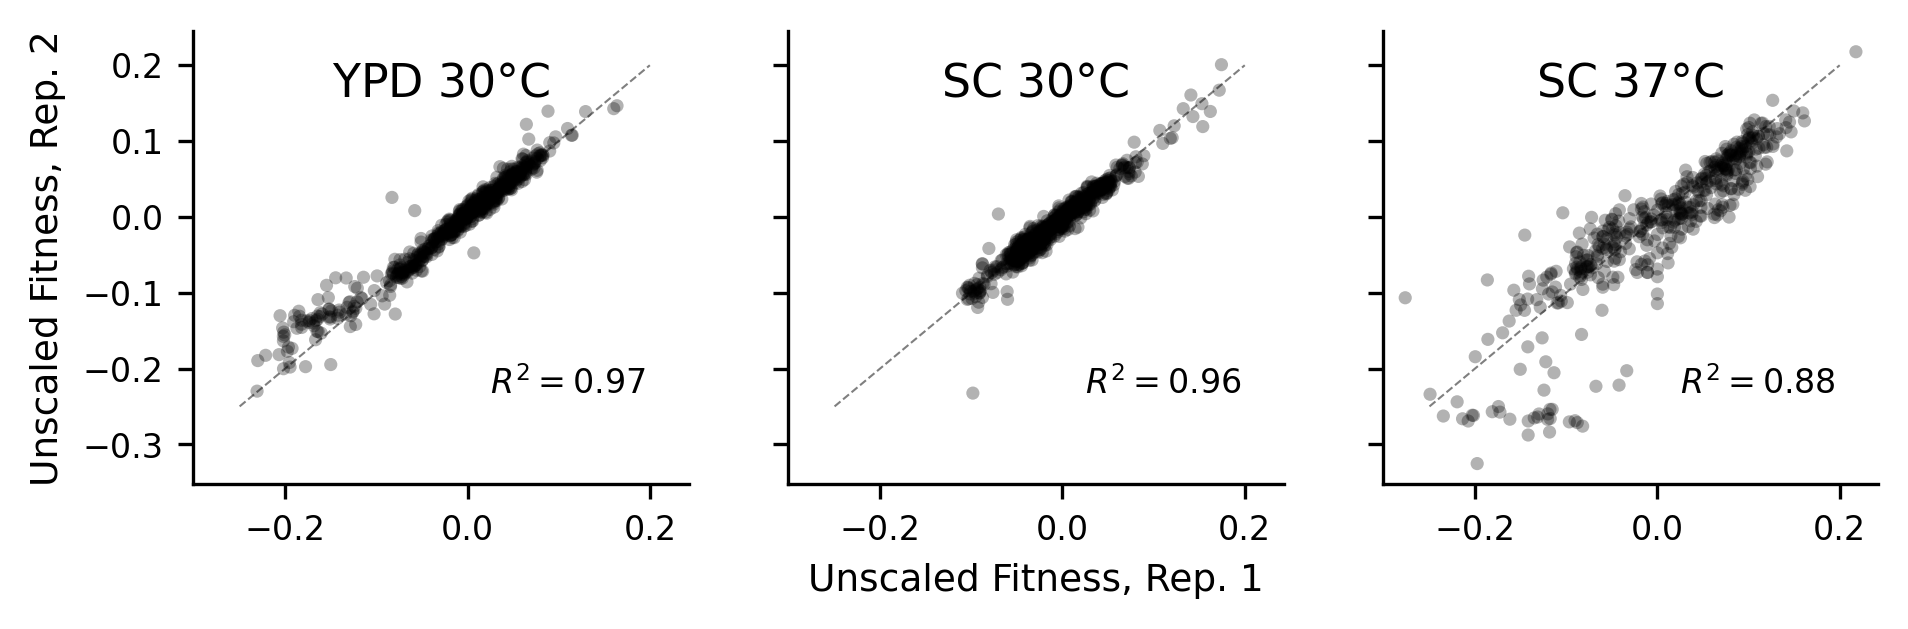

In [19]:
## Plotting s correlations
fig, subs = pl.subplots(1, 3, figsize=(7.25, 2), dpi=300, sharex=True, sharey=True)
p = 0
for plate in ['P1', 'P2', 'P3']:
    fd = pd.read_csv('../../Output/Fitness/' + plate + '_freq_and_s_data.csv')
    td = fd[fd['strain']!='BAD']
    subs[p].plot([-0.25, 0.2], [-0.25, 0.2], linestyle='dashed', c='k', alpha=0.5, lw=0.5)
    x, y = [], []
    for gen in fa_gens:
        x += list(td['Gen' + str(gen) + '_s_R1'])
        y += list(td['Gen' + str(gen) + '_s_R2'])
    subs[p].scatter(x, y, s=10, alpha=0.3, facecolors='k', edgecolors='none')
    subs[p].set_title(plate2env[plate], fontsize='11', y=0.8)
    lr = sci_stats.linregress([x[i] for i in range(len(x)) if (pd.notnull(x[i]) and pd.notnull(y[i]))],
                              [y[i] for i in range(len(x)) if (pd.notnull(x[i]) and pd.notnull(y[i]))])
    subs[p].annotate("$R^2=$"+str(lr[2])[:4], xy=(0.6,0.2), xycoords="axes fraction", fontsize=8)
    subs[p].tick_params(axis='both', which='major', labelsize=8)
    if p == 1:
        subs[p].set_xlabel('Unscaled Fitness, Rep. 1', fontsize=9)
    if p == 0:
        subs[p].set_ylabel('Unscaled Fitness, Rep. 2', fontsize=9)
    p += 1

sns.despine()
fig.savefig('../../Output/Figs/supp_figs/raw_s_correlations.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
fig.savefig('../../Output/Figs/supp_figs/raw_s_correlations.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)
   

# Figure 1

In [4]:
# these are wells that have no non-synonymous mutations present in the population at generation 70
# except the P1_a one, which is not a sequenced population, but has low gen 70 fitness like the only P1_alpha with no mutations
# (there are no a's with no non-synonymous mutations present at gen 70)
wells_for_anc_fitness = {
    'P1_a': ['P1D01'],
    'P1_alpha': ['P1B11'],
    'P1_diploid': ['P1B07', 'P1C07', 'P1C08', 'P1C09', 'P1E09', 'P1F07', 'P1F08', 'P1F10', 'P1G08', 'P1G09'],
    'P2_a': ['P2C02', 'P2C06'],
    'P2_alpha': ['P2B11', 'P2D11', 'P2E11', 'P2F11', 'P2G11'],
    'P2_diploid': ['P2B07', 'P2B08', 'P2B09', 'P2B10', 'P2C10', 'P2D08', 'P2F07', 'P2F09', 'P2G09', 'P2G10'],
    'P3_a': ['P3C05', 'P3G02'],
    'P3_alpha': ['P3D11', 'P3F11'],
    'P3_diploid': ['P3B07', 'P3B08', 'P3B10', 'P3C10', 'P3D09', 'P3D10', 'P3E08', 'P3F07', 'P3F09', 'P3G09', 'P3G10']
}

anc_fits = dict()
for plate in plates:
    g70_wells_per_strain = {s: [w[2:] for w in wells_for_anc_fitness[plate+'_'+s]] for s in strains}
    fd = fit_data[fit_data["plate"] == plate]
    anc_fits[plate] = {s: np.nanmedian(fd[fd['Well'].isin(g70_wells_per_strain[s])]['Gen70_s_scaled']) for s in strains}

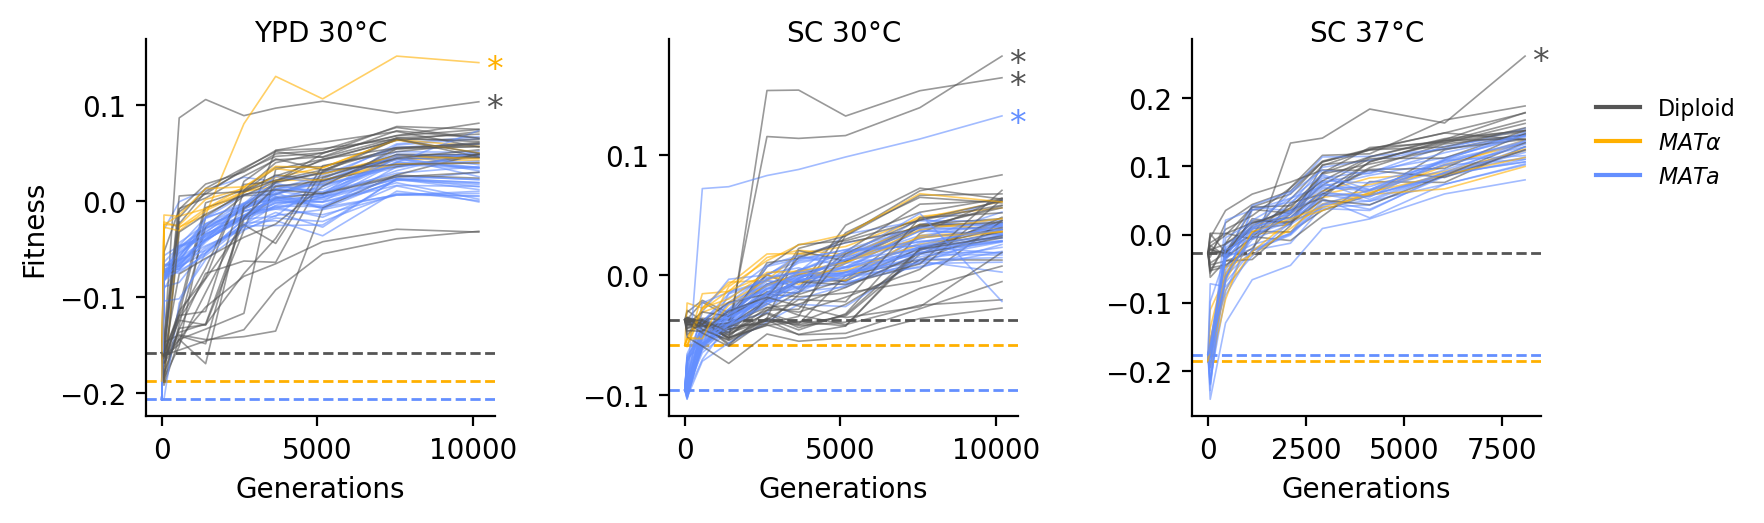

In [14]:
f, subs = pl.subplots(1, 3, figsize=(9, 2.5), dpi=200)

pl.subplots_adjust(wspace=0.5)
for p in range(3):
    plate = plates[p]
    fa_gens_use = [gen_fixer[g][plate] for g in fa_gens]
    td = fit_data[fit_data["plate"] == plate]
    for strain in strains:
        subs[p].axhline(y=anc_fits[plates[p]][strain], linestyle='--', color=color_by_strain[strain], lw=1)
    for row in td.as_matrix(['strain'] + ['Gen' + str(g) + '_s_scaled' for g in fa_gens]):
        subs[p].plot([0] + fa_gens_use, [anc_fits[plates[p]][row[0]]] + list(row[1:]), c=color_by_strain[row[0]], lw=0.6, alpha=0.6)
    
    subs[p].set_title(plate2env[plates[p]], fontsize=10, y=0.95)
    subs[p].set_xlabel('Generations')
    
for i in color_by_strain:    
    subs[2].plot([], [], c=color_by_strain[i], label=strains_for_print[i])
subs[2].legend(frameon=False, fontsize=8, bbox_to_anchor=(1.1, 0.9))
subs[0].set_ylabel('Fitness')

for well in wells_w_ade2_stop_lost:
    p = plates.index(well[:2])
    final_gen = gen_fixer[10150][well[:2]]
    final_fit = list(fit_data[fit_data["plate_well"] == well]['Gen10150_s_scaled'])[0]
    subs[p].annotate('$*$', fontsize=12, xy=(final_gen*1.05, final_fit-0.005), color=color_by_strain[well_to_strain[well]], horizontalalignment="center", verticalalignment='center')

sns.despine()
f.savefig('../../Output/Figs/Fig2_fitness.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/Fig2_fitness.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [6]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

# Significance testing for differences in final fitness gained

In [7]:
def get_fit_rate(row, gen1name, gen2name):
    if gen1name == 0:
        fit1 = anc_fits[row['plate']][row['strain']]
        gen1 = 0
    else:
        fit1 = row['Gen'+str(gen1name)+'_s_scaled']
        gen1 = gen_fixer[gen1name][row['plate']]
    fit2 = row['Gen'+str(gen2name)+'_s_scaled']
    gen2 = gen_fixer[gen2name][row['plate']]
    return 10000*(fit2-fit1)/(gen2-gen1)
                     

fit_data['first_half_gain'] = fit_data.apply(lambda row: get_fit_rate(row, 0, 5150), axis=1)
fit_data['second_half_gain'] = fit_data.apply(lambda row: get_fit_rate(row, 5150, 10150), axis=1)
fit_data['full_gain'] = fit_data.apply(lambda row: get_fit_rate(row, 0, 10150), axis=1)
fit_data['anc_fit'] = fit_data.apply(lambda row: anc_fits[row['plate']][row['strain']], axis=1)

In [8]:
fit_data['plate_well']

2     P1A03
3     P1A04
4     P1A05
5     P1A06
7     P1A08
      ...  
82    P3G11
85    P3H02
86    P3H03
87    P3H04
88    P3H05
Name: plate_well, Length: 205, dtype: object

P1 full_gain diploid 	 alpha 	 0.0013580593548950636 excluding... 0.0013580593548950636
P1 full_gain diploid 	 a 	 6.3020433172011e-06 excluding... 9.246101377644634e-06
P1 full_gain alpha 	 a 	 0.38288026216538473 excluding... 0.35293271981176016
P2 full_gain diploid 	 alpha 	 0.0187868293348178 excluding... 0.0187868293348178
P2 full_gain diploid 	 a 	 8.864317959739323e-10 excluding... 8.864317959739323e-10
P2 full_gain alpha 	 a 	 0.000137043015857765 excluding... 0.000137043015857765
P3 full_gain diploid 	 alpha 	 0.00018528860735729315 excluding... 0.00018528860735729315
P3 full_gain diploid 	 a 	 1.5202339490917527e-08 excluding... 1.5202339490917527e-08
P3 full_gain alpha 	 a 	 0.31739348664125905 excluding... 0.31739348664125905


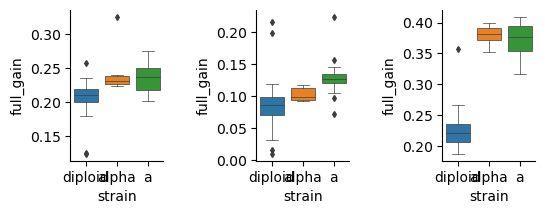

In [9]:
def compare_rates(col):
    excluded_wells = ['P1B03']
    f, subs = pl.subplots(1, 3, figsize=(6, 2), dpi=100)
    pl.subplots_adjust(wspace=1)
    fit_data['second_half_gain'] = fit_data['Gen10150_s_scaled']-fit_data['Gen5150_s_scaled']
    for p in range(3):
        plate = plates[p]
        td = fit_data[fit_data['plate']==plate]
        sns.boxplot(x="strain", y=col, data=td, ax=subs[p], order=strains, saturation=0.8, fliersize=3, linewidth=0.5)
        for i in range(3):
            for j in range(i+1, 3):
                s1 = strains[i]
                s2 = strains[j]
                d1 = td[td['strain']==s1][col]
                d2 = td[td['strain']==s2][col]
                d3 = td[~td['plate_well'].isin(excluded_wells)][td['strain']==s1][col]
                d4 = td[~td['plate_well'].isin(excluded_wells)][td['strain']==s2][col]
                print(plate, col, s1, '\t', s2, '\t', sci_stats.mannwhitneyu(list(d1), list(d2))[1], 'excluding...', sci_stats.mannwhitneyu(list(d3), list(d4))[1])
    sns.despine()
    
compare_rates('full_gain')

P1 first_half_gain diploid 	 alpha 	 0.0008756098179648924 excluding... 0.0008756098179648924
P1 first_half_gain diploid 	 a 	 0.00012794944939098808 excluding... 0.0001878887001838882
P1 first_half_gain alpha 	 a 	 0.10669930285539425 excluding... 0.08884371955029341
P2 first_half_gain diploid 	 alpha 	 0.0019202233931181142 excluding... 0.0019202233931181142
P2 first_half_gain diploid 	 a 	 8.385425417571385e-11 excluding... 8.385425417571385e-11
P2 first_half_gain alpha 	 a 	 1.3682469686849198e-05 excluding... 1.3682469686849198e-05
P3 first_half_gain diploid 	 alpha 	 0.00014670224147138135 excluding... 0.00014670224147138135
P3 first_half_gain diploid 	 a 	 7.86988577664301e-09 excluding... 7.86988577664301e-09
P3 first_half_gain alpha 	 a 	 0.037948943593689125 excluding... 0.037948943593689125


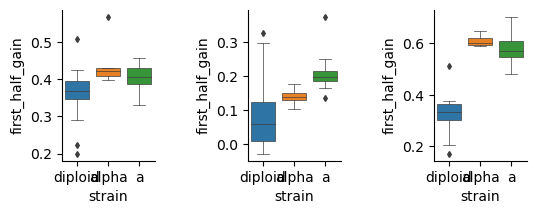

In [10]:
compare_rates('first_half_gain')

P1 second_half_gain diploid 	 alpha 	 0.49127008221200713 excluding... 0.49127008221200713
P1 second_half_gain diploid 	 a 	 0.01403331807321683 excluding... 0.017083922840068773
P1 second_half_gain alpha 	 a 	 0.07787311381355037 excluding... 0.08320159399581656
P2 second_half_gain diploid 	 alpha 	 0.0187868293348178 excluding... 0.0187868293348178
P2 second_half_gain diploid 	 a 	 4.431018796782944e-07 excluding... 4.431018796782944e-07
P2 second_half_gain alpha 	 a 	 0.03493888058593192 excluding... 0.03493888058593192
P3 second_half_gain diploid 	 alpha 	 0.24200496146908645 excluding... 0.24200496146908645
P3 second_half_gain diploid 	 a 	 0.010213161385315852 excluding... 0.010213161385315852
P3 second_half_gain alpha 	 a 	 0.15268159383311042 excluding... 0.15268159383311042


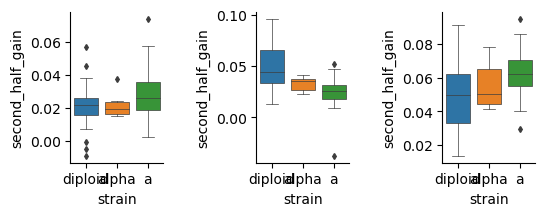

In [11]:
compare_rates('second_half_gain')

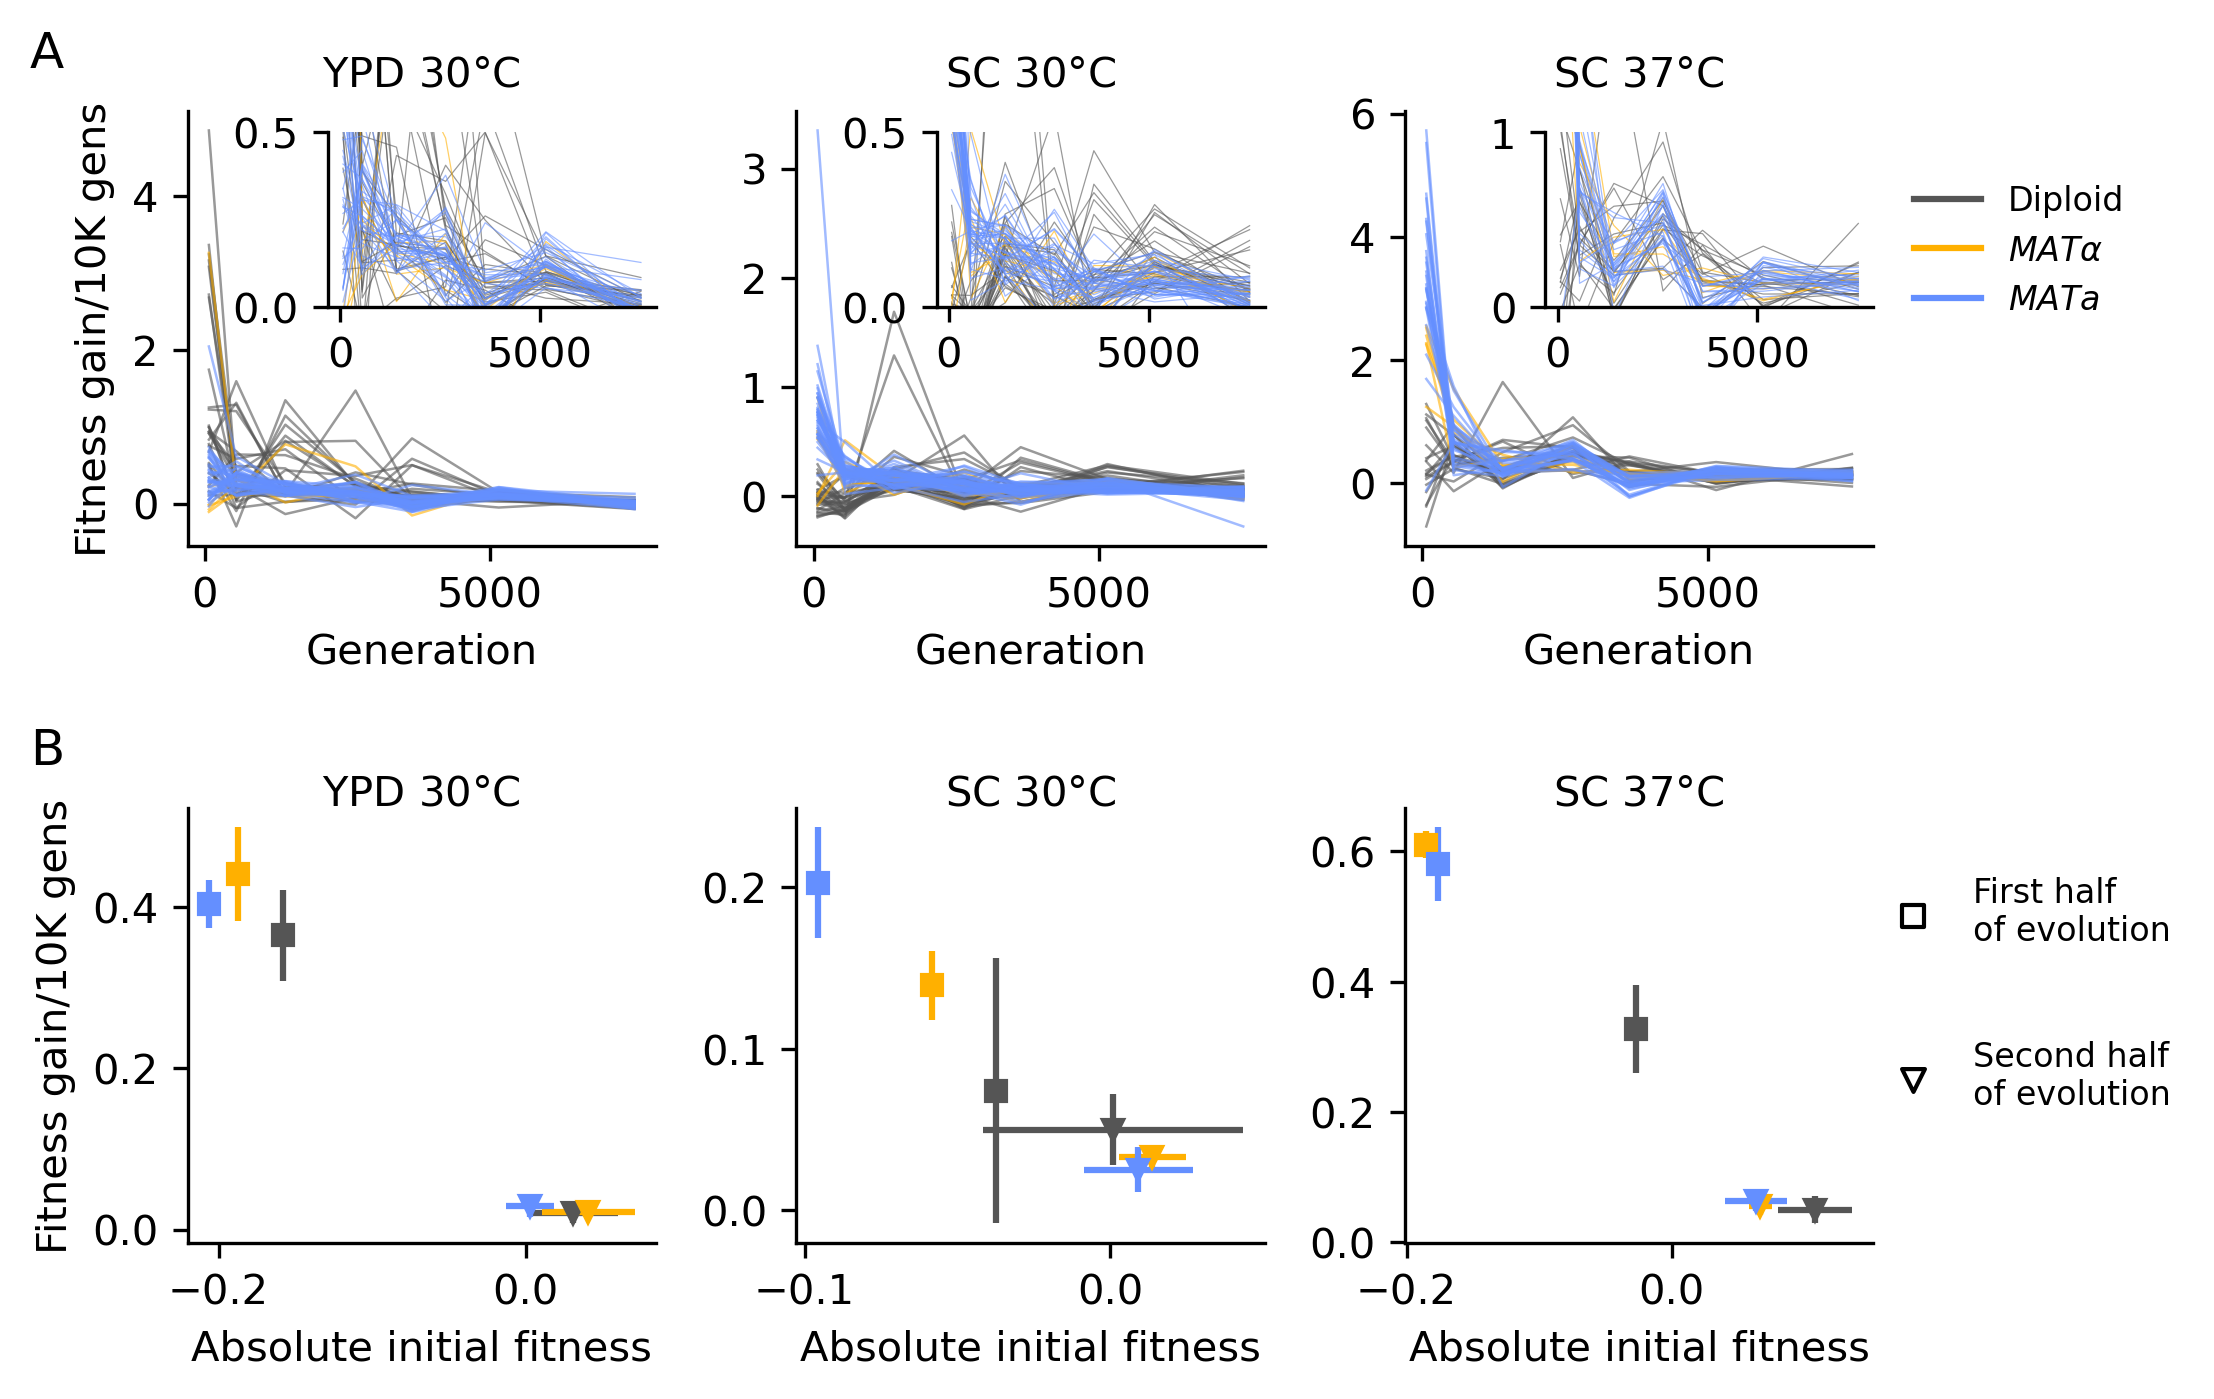

In [15]:
f, subps = pl.subplots(2, 3, figsize=(7.25, 5), dpi=300)

# PART A
pl.subplots_adjust(wspace=0.3, hspace=0.6)
subs = subps[0]
insets = []
ips = []
top_by_plate = {'P1': 0.5, 'P2': 0.5, 'P3': 1}
for p in range(3):
    plate = plates[p]
    # Create a set of inset Axes: these should fill the bounding box allocated to
    # them.
    insets.append(pl.axes([0,0,1,1], label=str(p)))
    # Manually set the position and relative size of the inset axes within ax1
    ips.append(InsetPosition(subs[p], [0.3,0.55,0.7,0.4]))
    insets[p].set_axes_locator(ips[p])
    for strain in strains:
        td = fit_data[(fit_data["plate"] == plate) & (fit_data["strain"] == strain)]
        for jnk, entry in td.iterrows():
            fixed_gens = [gen_fixer[g][plate] for g in fa_gens]
            fit_rec = [entry['Gen' + str(g) + '_s_scaled'] for g in fa_gens]
            derivs = [10000*(fit_rec[i+1]-fit_rec[i])/(fixed_gens[i+1]-fixed_gens[i]) for i in range(len(fit_rec)-1)]
            subs[p].plot(fa_gens[:-1], derivs, c=color_by_strain[strain], lw=0.6, alpha=0.6)
            insets[p].plot(fa_gens[:-1], derivs, c=color_by_strain[strain], lw=0.3, alpha=0.6)
    insets[p].set_ylim([0,top_by_plate[plate]])
    insets[p].set_yticks([0,top_by_plate[plate]])
    subs[p].set_title(plate2env[plates[p]], fontsize=10, y=1)
    subs[p].set_xlabel('Generation')
subs[0].set_ylabel('Fitness gain/10K gens')
subs[0].annotate('A', fontsize=12, xy=(-0.3, 1.1), xycoords="axes fraction", horizontalalignment="center")

for i in color_by_strain:    
    subs[2].plot([], [], c=color_by_strain[i], label=strains_for_print[i])
subs[2].legend(frameon=False, fontsize=8, bbox_to_anchor=(1.6, 0.9))

# PART B
subs = subps[1]
use_gens = [70, 5150]
for p in range(3):
    plate = plates[p]
    td = fit_data[fit_data["plate"] == plate]
    for strain in strains:
        tmp = td[td['strain']==strain]
        t0_fit = anc_fits[plate][strain]
        thalf_fit = list(tmp['Gen5150_s_scaled'])
        gain1 = list(tmp['first_half_gain'])
        gain2 = list(tmp['second_half_gain'])
        subs[p].errorbar(x=[t0_fit], y=[np.mean(gain1)], yerr=[np.std(gain1)], c=color_by_strain[strain], marker='s', markersize=5)
        subs[p].errorbar(x=[np.mean(thalf_fit)], y=[np.mean(gain2)], xerr=[np.std(thalf_fit)], yerr=[np.std(gain2)], c=color_by_strain[strain], marker='v', markersize=5)
        
    subs[p].set_title(plate2env[plate], fontsize=10, y=0.95)
    subs[p].set_xlabel('Absolute initial fitness', fontsize=10)
    
subs[2].scatter([], [], edgecolor='k', facecolor='w', marker='s', s=30, label='\nFirst half\nof evolution\n')
subs[2].scatter([], [], edgecolor='k', facecolor='w', marker='v', s=30, label='\nSecond half\nof evolution\n')
subs[2].legend(frameon=False, fontsize=8, bbox_to_anchor=(1.7, 1))

subs[0].set_ylabel('Fitness gain/10K gens', fontsize=10)
subs[0].annotate('B', fontsize=12, xy=(-0.3, 1.1), xycoords="axes fraction", horizontalalignment="center")
sns.despine()
f.savefig('../../Output/Figs/Fig2_supp1_declining_adaptability.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/Fig2_supp1_declining_adaptability.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)

## Old plot...

P1 diploid P = 1.2632586914886212e-84
P1 alpha P = 2.1645416654626712e-07
P1 a P = 1.830290884271353e-48
P2 diploid P = 5.500077067183436e-06
P2 alpha P = 1.5010447219689662e-15
P2 a P = 1.9125882927117557e-44
P3 diploid P = 8.567438590205564e-17
P3 alpha P = 1.1406989179639113e-17
P3 a P = 6.472967182612838e-77


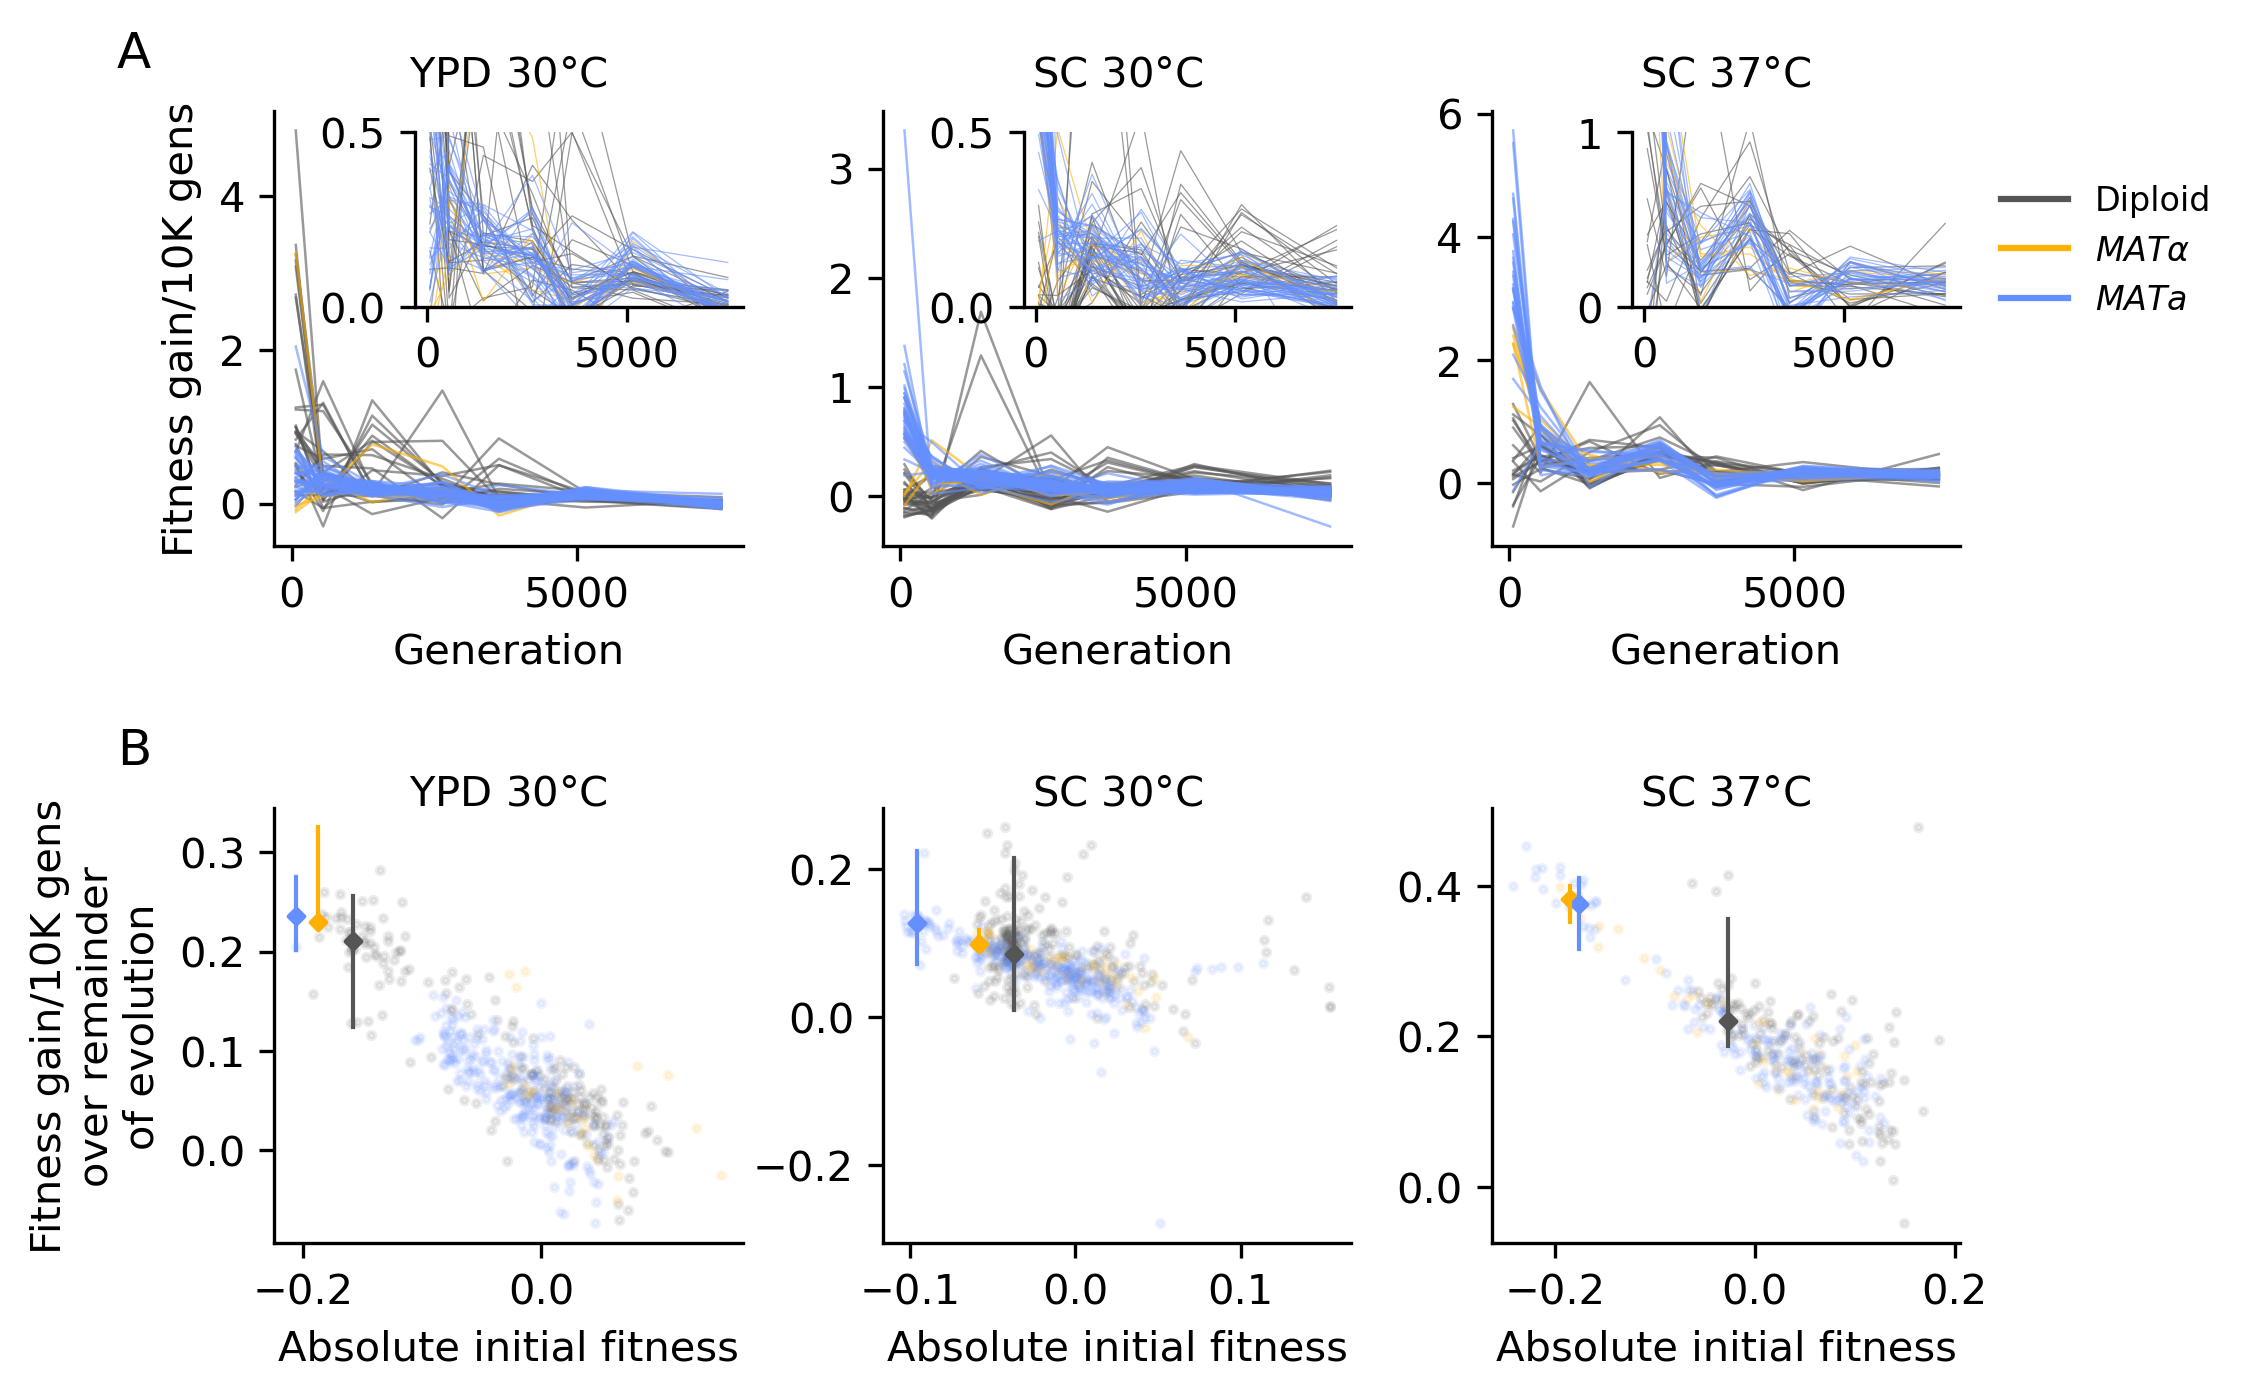

In [13]:
f, subps = pl.subplots(2, 3, figsize=(7.25, 5), dpi=300)

# PART A
pl.subplots_adjust(wspace=0.3, hspace=0.6)
subs = subps[0]
insets = []
ips = []
top_by_plate = {'P1': 0.5, 'P2': 0.5, 'P3': 1}
for p in range(3):
    plate = plates[p]
    # Create a set of inset Axes: these should fill the bounding box allocated to
    # them.
    insets.append(pl.axes([0,0,1,1], label=str(p)))
    # Manually set the position and relative size of the inset axes within ax1
    ips.append(InsetPosition(subs[p], [0.3,0.55,0.7,0.4]))
    insets[p].set_axes_locator(ips[p])
    for strain in strains:
        td = fit_data[(fit_data["plate"] == plate) & (fit_data["strain"] == strain)]
        for jnk, entry in td.iterrows():
            fixed_gens = [gen_fixer[g][plate] for g in fa_gens]
            fit_rec = [entry['Gen' + str(g) + '_s_scaled'] for g in fa_gens]
            derivs = [10000*(fit_rec[i+1]-fit_rec[i])/(fixed_gens[i+1]-fixed_gens[i]) for i in range(len(fit_rec)-1)]
            subs[p].plot(fa_gens[:-1], derivs, c=color_by_strain[strain], lw=0.6, alpha=0.6)
            insets[p].plot(fa_gens[:-1], derivs, c=color_by_strain[strain], lw=0.3, alpha=0.6)
    insets[p].set_ylim([0,top_by_plate[plate]])
    insets[p].set_yticks([0,top_by_plate[plate]])
    subs[p].set_title(plate2env[plates[p]], fontsize=10, y=1)
    subs[p].set_xlabel('Generation')
subs[0].set_ylabel('Fitness gain/10K gens')
subs[0].annotate('A', fontsize=12, xy=(-0.3, 1.1), xycoords="axes fraction", horizontalalignment="center")

for i in color_by_strain:    
    subs[2].plot([], [], c=color_by_strain[i], label=strains_for_print[i])
subs[2].legend(frameon=False, fontsize=8, bbox_to_anchor=(1.6, 0.9))

# PART B
subs = subps[1]
for p in range(3):
    plate = plates[p]
    fa_gens_use = [gen_fixer[g][plate] for g in fa_gens]
    td = fit_data[fit_data["plate"] == plate]
    for strain in strains:
        tmp = td[td['strain']==strain]
        initial_fits, fit_gains = [], []
        for row in tmp.as_matrix(['Gen' + str(g) + '_s_scaled' for g in fa_gens]):
            subs[p].scatter(row[:-1], [10000*(row[-1]-row[i])/(fa_gens_use[-1]-fa_gens_use[i]) for i in range(len(row)-1)], c=color_by_strain[strain], s=3, alpha=0.1, zorder=0)
            initial_fits += list(row[:-1])
            fit_gains += [10000*(row[-1]-row[i])/(fa_gens_use[-1]-fa_gens_use[i]) for i in range(len(row)-1)]
        i_f = [initial_fits[i] for i in range(len(initial_fits)) if pd.notnull(initial_fits[i]) and pd.notnull(fit_gains[i])]
        fg = [fit_gains[i] for i in range(len(initial_fits)) if pd.notnull(initial_fits[i]) and pd.notnull(fit_gains[i])]
        print(plates[p], strain, 'P =', sci_stats.linregress(i_f, fg)[3])
        all_fitness_gains = (10000/fa_gens_use[-1])*(tmp['Gen10150_s_scaled']-anc_fits[plates[p]][strain])
        subs[p].plot([anc_fits[plates[p]][strain], anc_fits[plates[p]][strain]], [np.nanmin(all_fitness_gains), np.nanmax(all_fitness_gains)], c=color_by_strain[strain], lw=1)
        subs[p].scatter([anc_fits[plates[p]][strain]], [np.nanmedian(all_fitness_gains)], c=color_by_strain[strain], s=7, marker='D')
    subs[p].set_title(plate2env[plates[p]], fontsize=10, y=0.95)
    subs[p].set_xlabel('Absolute initial fitness', fontsize=10)

subs[0].set_ylabel('Fitness gain/10K gens\nover remainder\nof evolution', fontsize=10)
subs[0].annotate('B', fontsize=12, xy=(-0.3, 1.1), xycoords="axes fraction", horizontalalignment="center")
sns.despine()
f.savefig('../../Output/Figs/Fig2_supp1_declining_adaptability.png', background='transparent', bbox_inches='tight', pad_inches=0.1)